In [1]:
import numpy as np

def dcg_at_k(r, k, method=0):
    """Score is discounted cumulative gain (dcg)

    Relevance is positive real values.  Can use binary
    as the previous methods.

    Example from
    http://www.stanford.edu/class/cs276/handouts/EvaluationNew-handout-6-per.pdf
    >>> r = [3, 2, 3, 0, 0, 1, 2, 2, 3, 0]
    >>> dcg_at_k(r, 1)
    3.0
    >>> dcg_at_k(r, 1, method=1)
    3.0
    >>> dcg_at_k(r, 2)
    5.0
    >>> dcg_at_k(r, 2, method=1)
    4.2618595071429155
    >>> dcg_at_k(r, 10)
    9.6051177391888114
    >>> dcg_at_k(r, 11)
    9.6051177391888114

    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
        k: Number of results to consider
        method: If 0 then weights are [1.0, 1.0, 0.6309, 0.5, 0.4307, ...]
                If 1 then weights are [1.0, 0.6309, 0.5, 0.4307, ...]

    Returns:
        Discounted cumulative gain
    """
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.


def ndcg_at_k(r, k, method=0):
    """Score is normalized discounted cumulative gain (ndcg)

    Relevance is positive real values.  Can use binary
    as the previous methods.

    Example from
    http://www.stanford.edu/class/cs276/handouts/EvaluationNew-handout-6-per.pdf
    >>> r = [3, 2, 3, 0, 0, 1, 2, 2, 3, 0]
    >>> ndcg_at_k(r, 1)
    1.0
    >>> r = [2, 1, 2, 0]
    >>> ndcg_at_k(r, 4)
    0.9203032077642922
    >>> ndcg_at_k(r, 4, method=1)
    0.96519546960144276
    >>> ndcg_at_k([0], 1)
    0.0
    >>> ndcg_at_k([1], 2)
    1.0

    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
        k: Number of results to consider
        method: If 0 then weights are [1.0, 1.0, 0.6309, 0.5, 0.4307, ...]
                If 1 then weights are [1.0, 0.6309, 0.5, 0.4307, ...]

    Returns:
        Normalized discounted cumulative gain
    """
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max


## Using same seed Set S for computing specificty for each semantic relationship

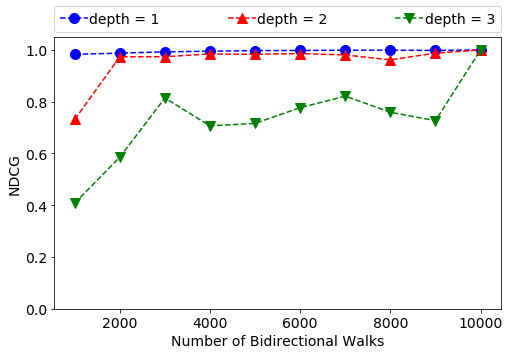

In [2]:
import numpy as np
import os, datetime
import matplotlib.pyplot as plt
import matplotlib
import datetime

dirname = './reverse_walks/num_walks/'

fnames = os.listdir(dirname)
fnames = np.sort([f for f in fnames if 'reverse' in f])
walks = list(np.arange(1000,10000+1,1000))
depths = np.arange(1,4)

results_ndcg = np.zeros((len(walks),len(depths)))
results_ndcg[-1,:] = np.ones((len(depths)))

refFiles = np.sort([f for f in fnames if '_' + str(walks[len(walks)-1]) + '_reverse' in f])

font = {'family' : 'sans-serif',
        'weight' : 'medium',
        'size'   : 14}

matplotlib.rc('font', **font)

for depth in depths:
    files_d = [f for f in fnames if 'depth_' + str(depth) in f]
    refFile = list(set(files_d).intersection(set(refFiles)))[0]
    refList = []
    for line in open(dirname + refFile):
        tokens = line.split(',')
        refList.append(','.join(tokens[:-1]))
    
    for wks in walks:
        rf = [f for f in files_d if str(wks) in f][0]
        if rf == refFile:
            continue
        compList = []
        for line in open(dirname + rf):
            tokens = line.split(',')
            compList.append(','.join(tokens[:-1]))
        pos = [len(refList) - refList.index(s) if s in refList else 0 for s in compList]
        result_ndcg = ndcg_at_k(pos,len(refList),1)
        results_ndcg[walks.index(wks),depth-1] = result_ndcg
        
fnames = os.listdir(dirname)
fnames = np.sort([f for f in fnames if 'statistics' in f])
results_time = np.zeros((len(walks),len(depths)))

for wks in walks:
    statfile = [f for f in fnames if str(wks) + '_statistics' in f][0]
    with open(dirname + statfile) as f:
        content = f.readlines()
    content = [c.strip().split(':')[1] for c in content if 'reverse' in c]
    results_time[walks.index(wks),:] = content[0:len(depths)]

styles = ['b--', 'r--', 'g--', 'y--','c--','m--','k--','b-', 'r-', 'g-', 'y-','c-','m-','k-']
markers = ['o', '^', 'v', 's','+','x','D','o', '^', 'v', 's','+','x','D']
#styles = ['bo', 'r^', 'g+', 'kx','co','mo']
plotHeight = 5
plotWidth = 8
fig, ax = plt.subplots(figsize=(plotWidth,plotHeight))

idx = 0
for depth in depths:
    YP = results_ndcg[:,depth-1]
    plt.plot(walks, YP, styles[idx], label='depth = ' + str(depth), marker = markers[idx], markersize = 10)
    idx = idx + 1

tt = 0.8*np.ones((len(walks),), dtype=float)
plt.xlabel('Number of Bidirectional Walks')

plt.ylim(0.0,1.05)
plt.ylabel('NDCG')
plt.legend(loc = 3, bbox_to_anchor=(0., 1.02, 1., .102),# fontsize = 'small',
          ncol=4, mode="expand", borderaxespad=0., handletextpad=0.1)
plt.savefig('./results/' + 'num_walks_ndcg.pdf', format='pdf', dpi=600, bbox_inches='tight')
plt.show()

# fig, ax = plt.subplots(figsize=(plotWidth,plotHeight))
# idx = 0
# for depth in depths:
#     YP = results_time[:,depth-1]
#     plt.plot(walks, YP, styles[idx], label='depth = ' + str(depth), marker = markers[idx], markersize = 10)
#     idx = idx + 1

# plt.xlabel('Number of Bidirectional Walks')
# plt.ylabel('Computation Time (sec)')
# plt.legend(loc = 3, bbox_to_anchor=(0., 1.02, 1., .102),# fontsize = 'small',
#            ncol=4, mode="expand", borderaxespad=0., handletextpad=0.1)
# plt.savefig('./results/' + 'num_walks_comp_time.pdf', format='pdf', dpi=600, bbox_inches='tight')
# plt.show()


For depth 1 and depth 2, there are fewer fluctuations now, given the same seed set $S$ is used in Algorithm 1 & 2. 
For depth 3, it needs to have a larger value of $N_{walks}$ as discussed in paper.